In [1]:
import h5py
import numpy as np

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
f5 = h5py.File("inpatient_readmission_analysis.hdf5", "r")

In [3]:
independent_array = f5["/independent/core_array"][...]
independent_array.shape

(66700, 5686)

In [4]:
independent_labels = f5["/independent/column_annotations"][...]
independent_labels[0: 10]

array(['age_at_visit_start_in_years_int', 'Length of stay in days',
       'gender_concept_id|8532',
       'Past history of 30-day inpatient readmissions',
       'No matching concept|0|C',
       'Gingival and periodontal disease|132344|C',
       'Staphylococcal scalded skin syndrome|132392|C',
       'Pressure ulcer stage 1|132393|C',
       'Post-laminectomy syndrome|132412|C',
       'Chronic osteomyelitis of hand|132414|C'],
      dtype='|S128')

In [4]:
dependent_array = f5["/dependent/core_array"][...]
dependent_array = np.ndarray.flatten(dependent_array)
dependent_array.shape

(66700,)

In [5]:
np.sum(dependent_array)

6420.0

In [6]:
np.sum(independent_array)

6006622

In [7]:
dependent_labels = f5["/dependent/column_annotations"][...]
dependent_labels

array([b'30-day inpatient readmission'], dtype='|S128')

In [8]:
import sklearn
sklearn.__version__

'0.19.2'

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(independent_array, dependent_array, test_size=0.2)

In [11]:
X_test

array([[73,  3,  0, ...,  0,  0,  0],
       [84,  5,  1, ...,  0,  0,  0],
       [76,  5,  0, ...,  0,  0,  0],
       ...,
       [80,  4,  1, ...,  0,  0,  0],
       [45, 11,  1, ...,  0,  0,  0],
       [71,  5,  1, ...,  0,  0,  0]])

In [12]:
from sklearn.pipeline import Pipeline

In [13]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [14]:
variance_thresh = VarianceThreshold()
select_k = SelectKBest(k=250)
random_forest = RandomForestClassifier(n_estimators=500)

pipeline_steps = [("remove_zero_variance", variance_thresh), 
                  ("select_features", select_k), 
                  ("random_forest", random_forest)]

In [15]:
pipeline_obj = Pipeline(pipeline_steps)

In [16]:
pipeline_obj.fit(X_train, Y_train)

Pipeline(memory=None,
     steps=[('remove_zero_variance', VarianceThreshold(threshold=0.0)), ('select_features', SelectKBest(k=250, score_func=<function f_classif at 0x000001AA62D21620>)), ('random_forest', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='a...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [17]:
Y_predict = pipeline_obj.predict(X_test)
Y_predict[0: 100]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [19]:
sum(Y_predict), Y_predict.shape

(71.0, (13340,))

In [19]:
from sklearn.metrics import classification_report

In [20]:
report = classification_report(Y_predict, Y_test)

In [21]:
print(report)

             precision    recall  f1-score   support

        0.0       1.00      0.90      0.95     13280
        1.0       0.01      0.17      0.01        60

avg / total       0.99      0.90      0.94     13340



In [22]:
from sklearn.metrics import roc_curve

In [23]:
Y_test_p = pipeline_obj.predict_proba(X_test)
Y_test_p[0: 10]

array([[ 0.88507775,  0.11492225],
       [ 0.62202046,  0.37797954],
       [ 0.92168129,  0.07831871],
       [ 0.85808104,  0.14191896],
       [ 1.        ,  0.        ],
       [ 0.91440862,  0.08559138],
       [ 0.94960468,  0.05039532],
       [ 0.91440862,  0.08559138],
       [ 0.92168129,  0.07831871],
       [ 0.91440862,  0.08559138]])

In [24]:
import matplotlib.pyplot as plt
import seaborn as sb

In [25]:
fpr, tpr, _ = roc_curve(Y_test, Y_test_p[:,1])

In [26]:
%matplotlib inline

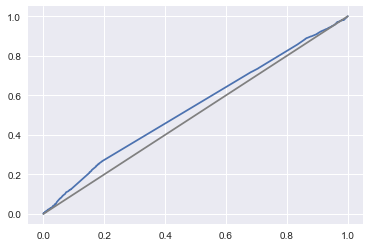

In [27]:
sb.set_style("darkgrid")
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], "k-", color="grey")

In [28]:
from sklearn.metrics import roc_auc_score

In [29]:
roc_auc_score(Y_test, Y_test_p[:,1])

0.53985723801100349

In [30]:
from sklearn.metrics import confusion_matrix

In [31]:
confusion_matrix(Y_test, Y_predict)

array([[11955,    50],
       [ 1325,    10]], dtype=int64)

In [32]:
variance_thresh.get_support()

array([ True,  True,  True, ..., False,  True,  True], dtype=bool)

In [33]:
selected_variables1 = independent_labels[variance_thresh.get_support()]

In [34]:
select_k.get_support().shape

(5432L,)

In [35]:
selected_variables2 = selected_variables1[select_k.get_support()]

In [36]:
selected_variables2.shape

(250L,)

In [37]:
features_importances = random_forest.feature_importances_

In [38]:
random_forest.feature_importances_.shape

(250L,)

In [39]:
import numpy as np

In [40]:
decreasing_order_of_features = np.argsort(-1*random_forest.feature_importances_,)

In [41]:
[(selected_variables2[decreasing_order_of_features][i], features_importances[decreasing_order_of_features][i]) 
 for i in range(features_importances.shape[0])]

[('Past history of 30-day inpatient readmissions', 0.064557083605340682),
 ('Biopsy of mouth, unspecified structure|2001200|P', 0.055621490256407578),
 ('End stage renal disease|193782|C', 0.04149588345465615),
 ('High risk drug monitoring status|440927|O', 0.025867138790944384),
 ('Long-term drug therapy|4141759|P', 0.025669174508722529),
 ('Body mass index 30+ - obesity|4060985|M', 0.020479903040990073),
 ('Repair of hypospadias or epispadias|2003874|P', 0.014604654029990687),
 ('Dysthymia|433440|C', 0.014492562632503781),
 ('Fall|436583|O', 0.012198520067470188),
 ('Adverse effect, due to correct medicinal substance properly administered|439221|C',
  0.012181759723598667),
 ('Seizure|377091|C', 0.012154861567498308),
 ('Cholangitis|195856|C', 0.011110525967680517),
 ('History of renal transplant|4059356|O', 0.010477358406969568),
 ('Percutaneous abdominal drainage|2003547|P', 0.010021297415778153),
 ('Abnormal patient reaction|433656|C', 0.0097756749388455497),
 ('Infection by methi